### Project Phase 3
#### Mohammad Amin Rami 98101588
#### Milad Heidari 98101469
#### Mohammad Reza Safavi 98106701

In [1]:
import torch
from pyturk.datasets import MSCTD, OpenViDial
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import(
    BertTokenizer,
    BertForSequenceClassification,
    DistilBertTokenizer,
    DistilBertModel,
    PerceiverModel,
    PerceiverImageProcessor,
    PerceiverConfig,
    PerceiverFeatureExtractor
)
from transformers.models.perceiver.modeling_perceiver import(
    PerceiverClassificationDecoder,
    PerceiverImagePreprocessor,
    PerceiverTextPreprocessor,
)
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.transforms import ToTensor, Compose, Resize
from transformers import CLIPModel, CLIPProcessor
from PIL import Image

import pandas as pd
import numpy as np
import pathlib
import random
import os
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# load train, dev and test datasets

train_dataset_orig = MSCTD(
    root='data',
    mode='train',
    download=False,
)

test_dataset_orig = MSCTD(
    root='data',
    mode='test',
    download=False,
)

INFO:root:opening and reading files...
INFO:root:opening and reading files...


### 1-1

In [4]:
# Create tokenizer for the bert model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased'
)

In [5]:
# Load image and text classifier
image_classifier = torch.load('resnet50_phase1.pt').to(device)
text_classifier = torch.load('bert_phase2.pt').to(device)

In [6]:
# Removing the last fully connected layer of the image classifier
image_classifier.fc = nn.Sequential(*image_classifier.fc[:7])

In [7]:
# Remove the last fully connected layer of the text classifier

text_classifier.dropout = nn.Identity()
text_classifier.classifier = nn.Identity()

In [8]:
image_classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
text_classifier

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

From the above configuration, out concatenated vector will be of size 64+768.

In [10]:
class CustomDataset(Dataset):
    
    def __init__(self, tokenizer, data, image_classifier, text_classifier, image_transform):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.image_classifier = image_classifier
        self.text_classifier = text_classifier
        self.image_classifier.eval()
        self.text_classifier.eval()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image, text, label = self.data[index]
        
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        text = tokenizer(
            text,
            padding='max_length',
            max_length=100,
            truncation=True,
            return_tensors='pt',
        )
        
        with torch.no_grad():
            # Get logits for image
            image = image.to(device).reshape(1, *image.shape)
            image_logits = self.image_classifier(image).squeeze()

            # Get logits for the text
            mask = text['attention_mask'].to(device)
            input_id = text['input_ids'].squeeze(1).to(device)
            outputs = text_classifier.bert(
                input_ids=input_id,
                attention_mask=mask,
            )
            text_logits = outputs[1].squeeze()
        
        concatenated_logits = torch.concatenate((image_logits, text_logits))
        
        return concatenated_logits, label

In [11]:
train_data = CustomDataset(
    tokenizer=tokenizer,
    data=train_dataset_orig,
    image_classifier=image_classifier,
    text_classifier=text_classifier,
    image_transform=ToTensor(),
)

test_data = CustomDataset(
    tokenizer=tokenizer,
    data=test_dataset_orig,
    image_classifier=image_classifier,
    text_classifier=text_classifier,
    image_transform=ToTensor(),
)

In [12]:
class MLPClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
          
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(832, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

In [13]:
model = MLPClassifier().to(device)

In [14]:
# define hyperparameters
learning_rate = 1e-4
batch_size = 8
epochs = 1

In [15]:
# create loss function and dataloader
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [16]:
predicted_labels = []
actual_labels = []

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 100 == 0:
            print(f'batch: {batch_num}, loss: {loss.item()}')
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            predicted_labels.extend(y_pred.argmax(dim=1).cpu())
            actual_labels.extend(y.cpu())
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [17]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
batch: 0, loss: 1.1168079376220703
batch: 100, loss: 0.21748235821723938
batch: 200, loss: 0.6896350979804993
batch: 300, loss: 0.06214183568954468
batch: 400, loss: 0.03819464147090912
batch: 500, loss: 0.012161371298134327
batch: 600, loss: 0.6945672035217285
batch: 700, loss: 0.382959246635437
batch: 800, loss: 0.08810721337795258
batch: 900, loss: 0.1785423755645752
batch: 1000, loss: 0.7427043914794922
batch: 1100, loss: 0.14959308505058289
batch: 1200, loss: 0.06341037154197693
batch: 1300, loss: 0.03239846229553223
batch: 1400, loss: 0.10969538986682892
batch: 1500, loss: 0.17368629574775696
batch: 1600, loss: 0.01154499500989914
batch: 1700, loss: 0.6333286762237549
batch: 1800, loss: 0.1456286460161209
batch: 1900, loss: 0.0740758627653122
batch: 2000, loss: 0.0842398926615715
batch: 2100, loss: 0.04800854250788689
batch: 2200, loss: 0.8521721363067627
batch: 2300, loss: 0.03954625129699707
batch: 2400, loss: 0.0290551

In [19]:
# torch.save(model, 'resnet_bert.pt')
model = torch.load('resnet_bert.pt')

In [21]:
# Classification report
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.44      0.61      0.51      1298
           1       0.72      0.61      0.66      2163
           2       0.61      0.53      0.57      1606

    accuracy                           0.59      5067
   macro avg       0.59      0.59      0.58      5067
weighted avg       0.61      0.59      0.59      5067



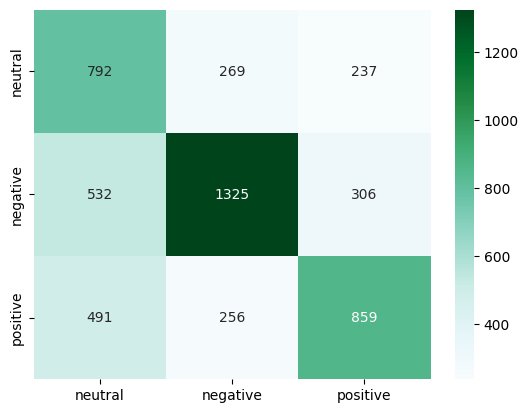

In [25]:
# Confusion Matrix
label_maps = ['neutral', 'negative', 'positive']
confmat = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(
    confmat,
    xticklabels=label_maps,
    yticklabels=label_maps,
    annot=True,
    fmt='d',
    cmap='BuGn'
);

### 1-2 (Clip + MLP)

In [4]:
# Initialize processor
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [5]:
# Initialize model
clip = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
clip.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [6]:
class CustomDataset2(Dataset):
    
    def __init__(self, embed_model, data, processor):
        self.data = data
        self.processor = processor
        self.embed_model = embed_model
        self.embed_model.eval()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        image, text, label = self.data[index]
        
        with torch.no_grad():
            
            inputs = self.processor(
                text=text,
                images=image,
                return_tensors='pt',
                padding=True
            )
            output = self.embed_model(**inputs.to(device))
            text_embeds = output.text_embeds.flatten()
            image_embeds = output.image_embeds.flatten()
            
        concat_embeds = torch.concatenate((text_embeds, image_embeds))
        
        return concat_embeds, label

In [7]:
# create training and test sets

train_data = CustomDataset2(
    data=train_dataset_orig,
    processor=processor,
    embed_model=clip
)

test_data = CustomDataset2(
    data=test_dataset_orig,
    processor=processor,
    embed_model=clip
)

In [8]:
class TextImageClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

In [9]:
model = TextImageClassifier().to(device)

In [12]:
# define hyperparameters
learning_rate = 1e-4
batch_size = 4
epochs = 3

In [13]:
# create loss function and dataloader
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [14]:
predicted_labels = []
actual_labels = []

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 100 == 0:
            print(f'batch: {batch_num}, loss: {loss.item()}')
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            predicted_labels.extend(y_pred.argmax(dim=1).cpu())
            actual_labels.extend(y.cpu())
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')
    

In [15]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    print()

epoch 1 ==================================================
batch: 0, loss: 1.1110637187957764
batch: 100, loss: 0.9956274628639221
batch: 200, loss: 1.1902170181274414
batch: 300, loss: 1.1032330989837646
batch: 400, loss: 1.0131819248199463
batch: 500, loss: 1.00348699092865
batch: 600, loss: 1.0735417604446411
batch: 700, loss: 1.2321919202804565
batch: 800, loss: 1.093709945678711
batch: 900, loss: 1.0208579301834106
batch: 1000, loss: 1.0006641149520874
batch: 1100, loss: 1.0060185194015503
batch: 1200, loss: 1.1156706809997559
batch: 1300, loss: 1.04714035987854
batch: 1400, loss: 1.0314202308654785
batch: 1500, loss: 1.0677456855773926
batch: 1600, loss: 1.0429465770721436
batch: 1700, loss: 1.0276182889938354
batch: 1800, loss: 1.0554625988006592
batch: 1900, loss: 1.051159381866455
batch: 2000, loss: 0.9282623529434204
batch: 2100, loss: 1.1629449129104614
batch: 2200, loss: 1.1057913303375244
batch: 2300, loss: 0.9543439745903015
batch: 2400, loss: 1.101118564605713
batch: 250

In [16]:
# torch.save(model, 'clip_mlp.pt')
model = torch.load('clip_mlp.pt')

In [17]:
# Classification report
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.43      0.50      0.46      3894
           1       0.62      0.74      0.67      6489
           2       0.62      0.38      0.47      4818

    accuracy                           0.56     15201
   macro avg       0.56      0.54      0.54     15201
weighted avg       0.57      0.56      0.55     15201



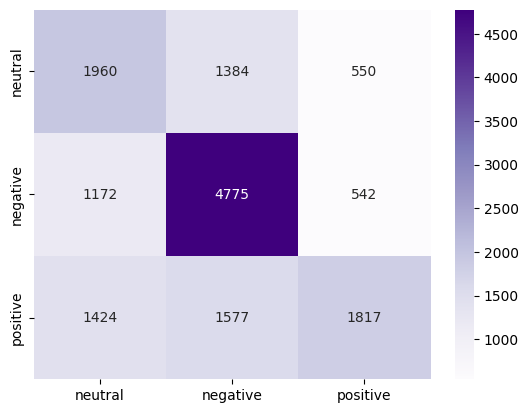

In [21]:
# Confusion Matrix
label_maps = ['neutral', 'negative', 'positive']
confmat = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(
    confmat,
    xticklabels=label_maps,
    yticklabels=label_maps,
    annot=True,
    fmt='d',
    cmap='Purples'
);

### 1-2 (Perceiver Model)

In [5]:
# Initialize processor
processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch32')

In [6]:
# Initialize model
clip = CLIPModel.from_pretrained('openai/clip-vit-base-patch32').to(device)
clip.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [7]:
class CustomDataset3(Dataset):
    
    def __init__(self, embed_model, data, processor):
        self.data = data
        self.processor = processor
        self.embed_model = embed_model
        self.embed_model.eval()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        image, text, label = self.data[index]
        
        with torch.no_grad():
            
            inputs = self.processor(
                text=text,
                images=image,
                return_tensors='pt',
                padding=True
            )
            output = self.embed_model(**inputs.to(device))
            text_embeds = output.text_embeds
            image_embeds = output.image_embeds
            
        concat_embeds = torch.concatenate((text_embeds, image_embeds), dim=1)
        
        return concat_embeds, label

In [8]:
# create training and test sets

train_data = CustomDataset3(
    data=train_dataset_orig,
    processor=processor,
    embed_model=clip
)

test_data = CustomDataset3(
    data=test_dataset_orig,
    processor=processor,
    embed_model=clip
)

In [9]:
# Create config of the model

config = PerceiverConfig()
config.num_labels = 3
config.d_model = 1024

In [10]:
class PerceiverClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.perceiver = PerceiverModel(
            config=config,
            decoder=PerceiverClassificationDecoder(
                config,
                num_channels=config.d_latents,
                trainable_position_encoding_kwargs=dict(num_channels=config.d_latents, index_dims=1),
                use_query_residual=True,
            ),
        )
        
        self.identity = nn.Identity()
        
    
    def forward(self, x):
        x = self.perceiver(x).logits
        return x

In [11]:
# Create a perceiver model
perceiver_classifier = PerceiverClassifier().to(device)

In [12]:
# define hyperparameters
learning_rate = 3e-5
batch_size = 1
epochs = 3

In [13]:
# create loss function and dataloader
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(perceiver_classifier.parameters(), lr=learning_rate, eps=1e-8)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 100 == 0:
            print(f'batch: {batch_num}, loss: {loss.item()}')
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [15]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, perceiver_classifier, loss_fn, optimizer)
    test_loop(test_dataloader, perceiver_classifier, loss_fn)
    print()

epoch 1 ==================================================


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 3.81 GiB total capacity; 2.53 GiB already allocated; 16.44 MiB free; 2.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### 2-1

In [4]:
# Create tokenizer for the bert model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased'
)

In [5]:
# Load image and text classifier
image_classifier = torch.load('resnet50_phase1.pt').to(device)
text_classifier = torch.load('bert_phase2.pt').to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'resnet50_phase1.pt'

In [ ]:
dataset = OpenViDial(
    data_path=pathlib.Path('./data/OpenViDial'),
    image_transform=Compose([
        Resize((64, 128)),
        ToTensor(),
    ]),
    text_transform=lambda x: tokenizer(
        x,
        padding='max_length',
        max_length=100,
        truncation=True,
        return_tensors='pt',
    )
)

In [7]:
# Extracting pseudo labels using text_classifier model
batch_size = 16
pseudo_labels = []

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
text_classifier.eval()

with torch.no_grad():
    for text, _ in tqdm(dataloader):
        # Get logits for the text
        mask = text['attention_mask'].to(device)
        input_id = text['input_ids'].squeeze(1).to(device)
        outputs = text_classifier(
            input_ids=input_id,
            attention_mask=mask,
        )
        
        text_logits = outputs.logits
        pseudo_labels.extend(nn.functional.softmax(text_logits, dim=1))

  0%|          | 0/3480 [00:00<?, ?it/s]

In [8]:
# Creating custom dataset for vision model learning

class VisionDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        _, image = self.data[index]
        label = self.labels[index]
        
        return image, label

In [9]:
# Train-test split for vision dataset

vision_dataset = VisionDataset(
    data=dataset,
    labels=pseudo_labels
)

train_size = int(0.8 * len(vision_dataset))
test_size = len(vision_dataset) - train_size
train_set, test_set = random_split(vision_dataset, [train_size, test_size])

In [10]:
# Training the vision model using pseudo labels from the text model

# define hyperparameters
learning_rate = 1e-3
batch_size = 16
epochs = 3

In [11]:
# create loss function and dataloader
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(image_classifier.parameters(), lr=learning_rate, eps=1e-8)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [12]:
predicted_labels = []
actual_labels = []

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num % 100 == 0:
            print(f'batch: {batch_num}, loss: {loss.item()}')
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            predicted_labels.extend(y_pred.argmax(dim=1).cpu())
            actual_labels.extend(y.argmax(dim=1).cpu())
            num_correct += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')

In [13]:
for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_loop(train_dataloader, image_classifier, loss_fn, optimizer)
    test_loop(test_dataloader, image_classifier, loss_fn)
    print()

epoch 1 ==================================================
batch: 0, loss: 0.2204660028219223
batch: 100, loss: 0.13178375363349915
batch: 200, loss: 0.12107579410076141
batch: 300, loss: 0.1280219554901123
batch: 400, loss: 0.1024543046951294
batch: 500, loss: 0.129855677485466
batch: 600, loss: 0.13010871410369873
batch: 700, loss: 0.10621442645788193
batch: 800, loss: 0.12876452505588531
batch: 900, loss: 0.10075634717941284
batch: 1000, loss: 0.11245086044073105
batch: 1100, loss: 0.12154191732406616
batch: 1200, loss: 0.10519742220640182
batch: 1300, loss: 0.0843239426612854
batch: 1400, loss: 0.131372332572937
batch: 1500, loss: 0.12041952461004257
batch: 1600, loss: 0.14739519357681274
batch: 1700, loss: 0.10339528322219849
batch: 1800, loss: 0.14102047681808472
batch: 1900, loss: 0.0972752496600151
batch: 2000, loss: 0.13379532098770142
batch: 2100, loss: 0.11595332622528076
batch: 2200, loss: 0.10784631967544556
batch: 2300, loss: 0.12544070184230804
batch: 2400, loss: 0.10637

In [15]:
# torch.save(image_classifier, 'domain_adaptation.pt')
image_classifier = torch.load('domain_adaptation.pt')

In [21]:
# Classification report
print(classification_report(actual_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.41      0.03      0.05     11142
           1       0.44      0.98      0.61     14610
           2       0.00      0.00      0.00      7650

    accuracy                           0.44     33402
   macro avg       0.28      0.34      0.22     33402
weighted avg       0.33      0.44      0.28     33402



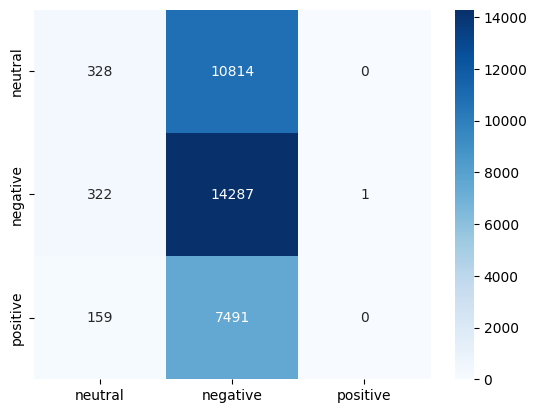

In [24]:
# Confusion Matrix
label_maps = ['neutral', 'negative', 'positive']
confmat = confusion_matrix(actual_labels, predicted_labels)
sns.heatmap(
    confmat,
    xticklabels=label_maps,
    yticklabels=label_maps,
    annot=True,
    fmt='d',
    cmap='Blues'
);